In [2]:
%load_ext autoreload
%autoreload 
import matplotlib.pyplot as plt
import csv

In [ ]:
b_losses = []
d_losses = []

with open('/home/lcur1339/dl2-cgn/cgn_framework/imagenet/experiments/bgn_2022_05_29_13_02_tmp/losses/losses.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(lines):
        if i == 0: b_losses = row[1:]
        else: d_losses = row[1:]


In [ ]:
b_losses = [round(float(elem), 3) for elem in b_losses ]
d_losses = [round(float(elem), 3) for elem in d_losses]
print(b_losses[:10])

[]


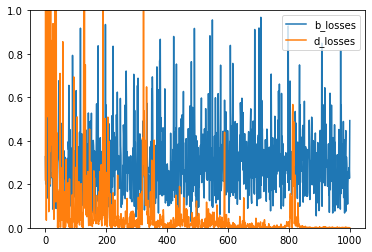

In [ ]:
plt.plot(b_losses[::10], label='b_losses')
plt.plot(d_losses[::10], label='d_losses')
#plt.plot(d_losses, label='d_losses')
ax = plt.gca()
ax.set_ylim([0,1])
plt.legend()
plt.show()

In [3]:
from imagenet.models import CGN
from imagenet.models.gp_gan import BlendNet

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision

In [11]:
cgn = CGN(1)
weights = torch.load("imagenet/weights/cgn.pth", map_location=torch.device('cpu'))
weights = {k.replace('module.', ''): v for k, v in weights.items()}
cgn.load_state_dict(weights)

<All keys matched successfully>

In [12]:
x_gt, mask, _, foreground, background, _ = cgn()
img_comp = mask * foreground + (1 - mask) * background

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Mask')

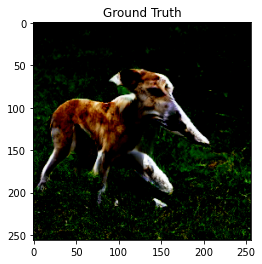

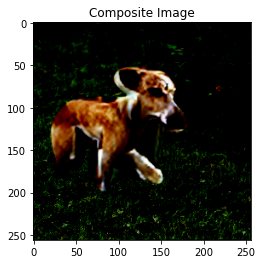

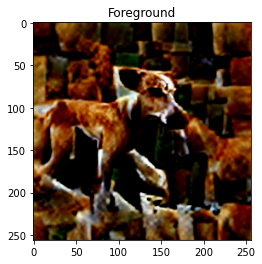

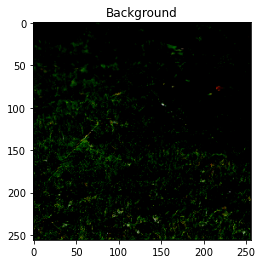

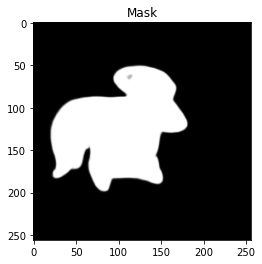

In [13]:
# printing the results
plt.imshow(x_gt.detach().squeeze(0).transpose(1,0).transpose(2,1))
plt.title('Ground Truth')
plt.figure()
plt.imshow(img_comp.detach().squeeze(0).transpose(1,0).transpose(2,1))
plt.title('Composite Image')
plt.figure()
plt.imshow(foreground.detach().squeeze(0).transpose(1,0).transpose(2,1))
plt.title('Foreground')
plt.figure()
plt.imshow(background.detach().squeeze(0).transpose(1,0).transpose(2,1))
plt.title('Background')
plt.figure()
plt.imshow(mask.detach().squeeze(), cmap='gray')
plt.title('Mask') 



In [14]:
# loading the blend net
model = BlendNet()

PATH = "./imagenet/weights/blend_net_weights.pth" 
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
def gradient_info_print(named_parameters):
    num_p = 0
    sum_norms = 0
    layers = []
    grads_per_layer = []
    for n, param in named_parameters:
        num_p += param.numel()
        sum_norms += torch.norm(param)
        print(torch.norm(param))
        if(param.requires_grad) and ("bias" not in n) and param is not None:
            layers.append(n)
            if param.grad is not None:
                grads_per_layer.append(param.grad.abs().mean())

    return (num_p, sum_norms, sum_norms/num_p, grads_per_layer)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


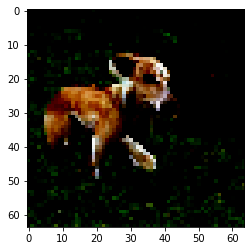

In [34]:
# model expects 64x64 imgs so resize...
img_resz = torchvision.transforms.functional.resize(img_comp, size=(64,64))
plt.imshow(img_resz.squeeze(0).detach().numpy().transpose(1,2,0))

In [35]:
# attempting to track the gradients
model.train()
xl_from_net = model(img_resz)#.squeeze(0))
print(xl_from_net.size())
#plt.imshow(xl_from_net.detach().squeeze(0).numpy().transpose(1,2,0))
print(xl_from_net.max())
print(xl_from_net.min())
opt = torch.optim.Adam(model.parameters(),lr=0, betas=(0.9, 0.999))
x_gt_rsz = torchvision.transforms.functional.resize(x_gt, size=(64,64))
loss = torch.nn.MSELoss()(xl_from_net, x_gt_rsz)
loss.backward(retain_graph=True)
opt.step()

num_p, sum_norms, avg_param_size, grads_per_layer = gradient_info_print(model.named_parameters())


torch.Size([1, 3, 64, 64])
tensor(0.4037, grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<MinBackward1>)
tensor(1.2569, grad_fn=<CopyBackwards>)
tensor(0., grad_fn=<CopyBackwards>)
tensor(2.4712, grad_fn=<CopyBackwards>)
tensor(0.6501, grad_fn=<CopyBackwards>)
tensor(9.9628, grad_fn=<CopyBackwards>)
tensor(0.2097, grad_fn=<CopyBackwards>)
tensor(13.8401, grad_fn=<CopyBackwards>)
tensor(0.2088, grad_fn=<CopyBackwards>)
tensor(19.2472, grad_fn=<CopyBackwards>)
tensor(0.2134, grad_fn=<CopyBackwards>)
tensor(33.0810, grad_fn=<CopyBackwards>)
tensor(0.4187, grad_fn=<CopyBackwards>)
tensor(32.8298, grad_fn=<CopyBackwards>)
tensor(0.1622, grad_fn=<CopyBackwards>)
tensor(19.3722, grad_fn=<CopyBackwards>)
tensor(0.1611, grad_fn=<CopyBackwards>)
tensor(13.7369, grad_fn=<CopyBackwards>)
tensor(0.1801, grad_fn=<CopyBackwards>)
tensor(9.9744, grad_fn=<CopyBackwards>)
tensor(0.1716, grad_fn=<CopyBackwards>)
tensor(2.5750, grad_fn=<CopyBackwards>)
tensor(0.1033, grad_fn=<CopyBackwards>)


In [39]:
print(avg_param_size)
print(grads_per_layer)

tensor(2.2635e-06, grad_fn=<DivBackward0>)
[tensor(0.0054), tensor(0.0002), tensor(0.0002), tensor(0.0003), tensor(0.0001), tensor(0.0002), tensor(0.0012), tensor(0.0021), tensor(0.0029), tensor(0.0153)]


: 

from experiments:
min,max: (0, 0.126), (0, 0.36), (0, 23.9), (0, 326.14), (0, 2381.92)
avg weight:  (2.0766e-06), (2.0797e-06), (2.0980e-06), (2.1245e-06)

## gradient printing &#8593; output testing &#8595;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


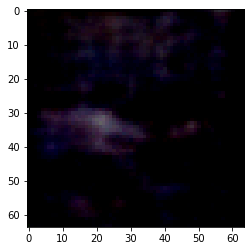

In [ ]:
model.eval()
xl_from_net = model(img_resz)#.squeeze(0))
print(xl_from_net.size())
plt.imshow(xl_from_net.detach().squeeze(0).numpy().transpose(1,2,0))
print(xl_from_net.max())
print(xl_from_net.min())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


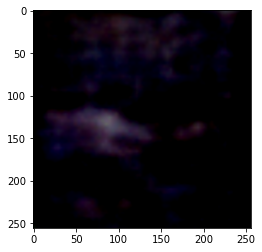

In [ ]:
xl = torchvision.transforms.functional.resize(xl_from_net, size=(256,256))
plt.imshow(xl.detach().squeeze(0).numpy().transpose(1,2,0))

In [ ]:
# from imagenet.train_bgan import save_sample_sheet

# save_sample_sheet(model, cgn, "imagenet/experiments", '0')

PermissionError: [Errno 13] Permission denied: '/home/lcur1339/dl2-cgn/cgn_framework/imagenet/experiments/blendnetinput.png'

: 